In [2]:
import pandas as pd
import matplotlib.pyplot as plt

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
save_dir = f"{processed_log_dir}/dlrm/"
log_dir = f"{logs}/resultats_11-23/"
path = f"{log_dir}/dlrm/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])


In [8]:
jobs.dtypes

job                                                       int64
energy_kWh                                              float64
energy_joule                                            float64
energy_consumption_since_previous_measurement_milliJ    float64
job_id                                                    int64
file                                                     object
start_time_ms                                           float64
end_time_ms                                             float64
epoch_nb                                                  int64
block_nb                                                  int64
eval_nb                                                   int64
mllog_submission_benchmark                               object
mllog_submission_org                                     object
mllog_submission_division                                object
mllog_submission_status                                  object
mllog_submission_platform               

In [10]:
cols = ['mllog_eval_accuracy','energy_kWh','node_nb',  'mllog_gradient_accumulation_steps','block_nb', 
        'mllog_train_samples', 
        'eval_nb',
        'mllog_global_batch_size',
        'mllog_opt_base_learning_rate',
       'mllog_eval_samples', 
        ]
cols = [x for x in jobs.columns if jobs[x].dtype != "object"]
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.max_rows', 67)
jobs[cols].style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

,job,energy_kWh,energy_joule,energy_consumption_since_previous_measurement_milliJ,job_id,start_time_ms,end_time_ms,epoch_nb,block_nb,eval_nb,mllog_eval_samples,mllog_global_batch_size,mllog_opt_base_learning_rate,mllog_sgd_opt_base_learning_rate,mllog_sgd_opt_learning_rate_decay_poly_power,mllog_opt_learning_rate_warmup_steps,mllog_opt_learning_rate_warmup_factor,mllog_lr_decay_start_steps,mllog_sgd_opt_learning_rate_decay_steps,mllog_gradient_accumulation_steps,mllog_eval_accuracy,mllog_train_samples,node_nb
0,126279,0.142229,512022.810775,512022810.774902,126279,nan,nan,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802610,3775334400,1
1,126280,0.143492,516572.246599,516572246.598511,126280,1699318499000.000000,1699318751000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802615,3775334400,1
2,126281,0.143677,517236.468343,517236468.343140,126281,1699318826000.000000,1699319078000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802649,3775334400,1
3,126282,0.143914,518090.859526,518090859.525879,126282,1699319153000.000000,1699319404000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802608,3775334400,1
4,126283,0.142232,512034.640697,512034640.697021,126283,nan,nan,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802668,3775334400,1
5,126295,0.148527,534696.058192,534696058.191772,126295,1699287628000.000000,1699287878000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802836,3775334400,1
6,126296,0.147810,532115.949244,532115949.243652,126296,1699287982000.000000,1699288230000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802610,3775334400,1
7,126297,0.149578,538481.754371,538481754.371094,126297,1699288334000.000000,1699288583000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802580,3775334400,1
8,126298,0.150283,541017.454526,541017454.525757,126298,1699288688000.000000,1699288938000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802652,3775334400,1
9,126299,0.148638,535097.958411,535097958.410522,126299,1699289042000.000000,1699289292000.000000,1,0,18,89137319,55296,24.000000,24.000000,2.000000,2750,0.000000,49315,27772,1,0.802731,3775334400,1


# Conducted experiments

In [16]:
cols=['cmd_learning_rate', 'cmd_max_steps']
gp_by = ["node_nb", "mllog_gradient_accumulation_steps"] # "sub_seed" 
jobs[gp_by+["job_id"]].groupby(gp_by).count()["job_id"]

node_nb  mllog_gradient_accumulation_steps
1        1                                    25
Name: job_id, dtype: int64

We tested several values for the number of samples (sub_num-sample) and the target accuracy (sub_target-acc). The batch size is not identical for each node number.

In [6]:
jobs[gp_by+["eval_nb"]].groupby(gp_by).mean()["eval_nb"]

node_nb
1    18.0
Name: eval_nb, dtype: float64

It seems that the execution with a dataset of 225000 didn't go well - only one evaluation was done.

# Preprocessing

In [14]:
# jobs["sub_num-sample"] = jobs["sub_num-sample"].fillna(14000000)
# jobs["cmd_train_batch_size"] = jobs["cmd_train_batch_size"].astype(int)
# jobs["cmd_max_samples_termination"] = jobs["cmd_max_samples_termination"].astype(int)

# Computing the total number of images processed, which seems like the most relevant metric regarding energy consumption
# jobs["total_batch_size"]=jobs["mllog_d_batch_size"]*jobs["node_nb"]*8
jobs["images_processed"] = jobs["epoch_nb"]*jobs["mllog_global_batch_size"]

In [42]:
jobs["energy_kWh"].agg(["mean", "std"])

mean    0.148042
std     0.002607
Name: energy_kWh, dtype: float64

In [44]:
(jobs["energy_kWh"].max()-jobs["energy_kWh"].min())/jobs["energy_kWh"].max()
# diff de 5% entre le max et le min

0.053592806495070554

# Result exploration

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_43832/3688345640.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

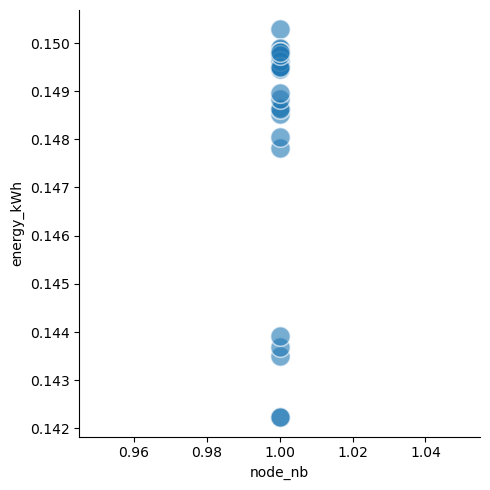

In [10]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.relplot(
    data=jobs,
    x="node_nb", y="energy_kWh", s=200, alpha=0.6, palette="flare"
)

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_43832/1528417309.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

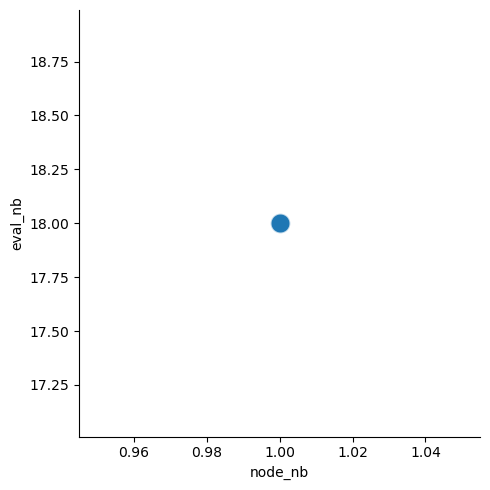

In [17]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.relplot(
    data=jobs,
    x="node_nb", y="eval_nb",s=200, alpha=0.6, palette="flare"
)

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_43832/1479692121.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

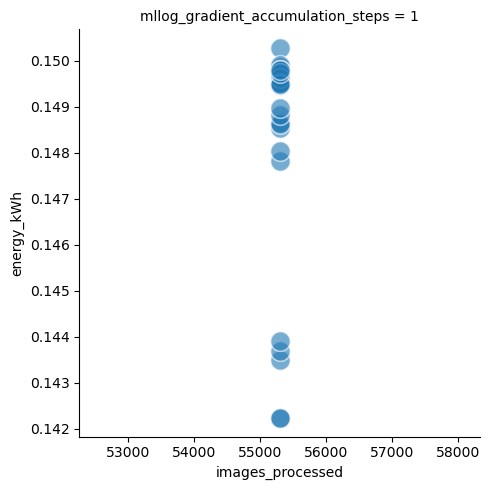

In [19]:
import seaborn as sns
plt.figure(figsize=(15,8))

sns.relplot(
    data=jobs, #&(jobs["mllog_eval_accuracy"]>0.72)&((jobs["mllog_d_batch_size"]==48)|(jobs["mllog_d_batch_size"]==56))],
    x="images_processed", y="energy_kWh", col="mllog_gradient_accumulation_steps", s=200, alpha=0.6, palette="flare",
)

# Accuracy
mllog_eval_accuracy, mllog_train_samples, images_processed, epoch_nb, block_nb, eval_nb

In [20]:
plot_df = jobs

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

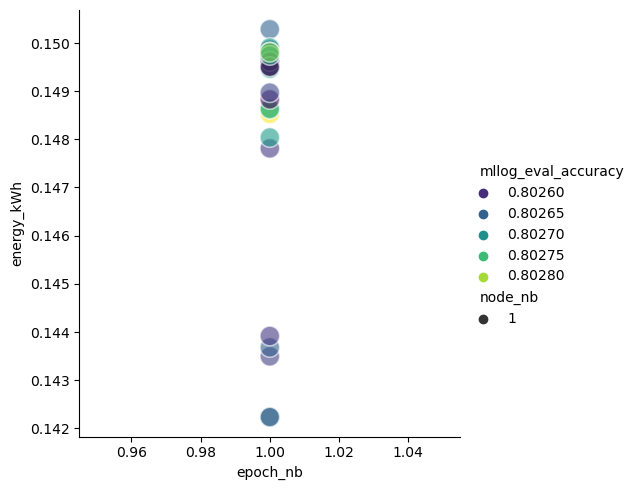

In [22]:
les_x = "epoch_nb"

plt.figure(figsize=(15,8))
sns.relplot(
    data=plot_df,
    x=les_x, y="energy_kWh", hue="mllog_eval_accuracy", style="node_nb", s=200, alpha=0.6, palette="viridis"
)

## MLLOGS details

In [25]:
jobs.head()

,job,energy_kWh,energy_joule,energy_consumption_since_previous_measurement_milliJ,job_id,file,start_time_ms,end_time_ms,epoch_nb,block_nb,...,mllog_opt_learning_rate_warmup_steps,mllog_opt_learning_rate_warmup_factor,mllog_lr_decay_start_steps,mllog_sgd_opt_learning_rate_decay_steps,mllog_gradient_accumulation_steps,mllog_eval_accuracy,mllog_tracked_stats,mllog_train_samples,node_nb,images_processed
0,126279,0.142229,512022.810775,5.120228e+08,126279,/Users/mathildepro/Documents/code_projects/hpe...,NaN,NaN,1,0,...,2750,0.0,49315,27772,1,0.802610,{'throughput': 24695281.15},3775334400,1,55296
1,126280,0.143492,516572.246599,5.165722e+08,126280,/Users/mathildepro/Documents/code_projects/hpe...,1.699318e+12,1.699319e+12,1,0,...,2750,0.0,49315,27772,1,0.802615,{'throughput': 24119170.12},3775334400,1,55296
2,126281,0.143677,517236.468343,5.172365e+08,126281,/Users/mathildepro/Documents/code_projects/hpe...,1.699319e+12,1.699319e+12,1,0,...,2750,0.0,49315,27772,1,0.802649,{'throughput': 24084101.21},3775334400,1,55296
3,126282,0.143914,518090.859526,5.180909e+08,126282,/Users/mathildepro/Documents/code_projects/hpe...,1.699319e+12,1.699319e+12,1,0,...,2750,0.0,49315,27772,1,0.802608,{'throughput': 24287638.2},3775334400,1,55296
4,126283,0.142232,512034.640697,5.120346e+08,126283,/Users/mathildepro/Documents/code_projects/hpe...,NaN,NaN,1,0,...,2750,0.0,49315,27772,1,0.802668,{'throughput': 24615242.51},3775334400,1,55296


In [11]:
plot_df = jobs[(jobs["job"]==126279)]

file = plot_df.file.values[0]
file.split("/")[-2:]

import sys
sys.path.append("../../../logging/mlperf_logging")

from compliance_checker.mlp_parser import parse_file

log_file = path + "/".join(file.split("/")[-2:])
print(log_file)

loglines, _ = parse_file(log_file, ruleset="2.1.0")
mllog = pd.DataFrame(loglines)
mllog

/Users/mathildepro/Documents/code_projects/hpe_logs/resultats_nov/dlrm/126279/231106154356001464926_raw_1.log


,full_string,timestamp,key,value,lineno
0,":::MLLOG {""...",1.699282e+12,submission_...,{'value': '...,0
1,":::MLLOG {""...",1.699282e+12,submission_org,{'value': '...,1
2,":::MLLOG {""...",1.699282e+12,submission_...,{'value': '...,2
3,":::MLLOG {""...",1.699282e+12,submission_...,{'value': '...,3
4,":::MLLOG {""...",1.699282e+12,submission_...,{'value': '...,4
...,...,...,...,...,...
80,":::MLLOG {""...",1.699282e+12,eval_accuracy,{'value': 0...,80
81,":::MLLOG {""...",1.699282e+12,tracked_stats,{'value': {...,81
82,":::MLLOG {""...",1.699282e+12,epoch_stop,{'value': N...,82
83,":::MLLOG {""...",1.699282e+12,run_stop,{'value': N...,83


In [12]:
def get_value(row):
    """Get key value pairs from mllog rows."""
    for key, value in row['metadata'].items():
        row["meta_"+key] = value
    return row

mllog['metadata'] = mllog.apply(lambda row: row['value']['metadata'], axis=1)
mllog['value'] = mllog.apply(lambda row: row['value']['value'], axis=1)
mllog = mllog.apply(get_value, axis=1)
mllog

,full_string,key,lineno,meta_epoch_num,meta_file,meta_lineno,meta_status,meta_step,meta_tensor,metadata,timestamp,value
0,":::MLLOG {""...",submission_...,0,NaN,/workspace/...,52,NaN,NaN,NaN,{'file': '/...,1.699282e+12,dlrm
1,":::MLLOG {""...",submission_org,1,NaN,/workspace/...,57,NaN,NaN,NaN,{'file': '/...,1.699282e+12,HPE
2,":::MLLOG {""...",submission_...,2,NaN,/workspace/...,61,NaN,NaN,NaN,{'file': '/...,1.699282e+12,closed
3,":::MLLOG {""...",submission_...,3,NaN,/workspace/...,65,NaN,NaN,NaN,{'file': '/...,1.699282e+12,onprem
4,":::MLLOG {""...",submission_...,4,NaN,/workspace/...,69,NaN,NaN,NaN,{'file': '/...,1.699282e+12,1xSUBMISSIO...
...,...,...,...,...,...,...,...,...,...,...,...,...
80,":::MLLOG {""...",eval_accuracy,80,1.899905,/workspace/...,158,NaN,NaN,NaN,{'file': '/...,1.699282e+12,0.80261
81,":::MLLOG {""...",tracked_stats,81,NaN,/workspace/...,148,NaN,0.899905,NaN,{'file': '/...,1.699282e+12,{'throughpu...
82,":::MLLOG {""...",epoch_stop,82,2.000000,/workspace/...,158,NaN,NaN,NaN,{'file': '/...,1.699282e+12,None
83,":::MLLOG {""...",run_stop,83,NaN,/workspace/...,158,success,NaN,NaN,{'file': '/...,1.699282e+12,None


<Axes: xlabel='timestamp'>

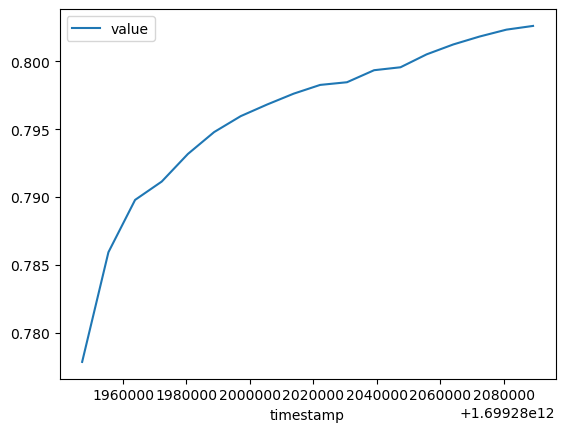

In [13]:
mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].plot(x="timestamp", y="value")

In [14]:
(mllog[mllog["key"]=="block_start"]["timestamp"].min() - plot_df["start_time_ms"].values[0])/1000/60

nan

# Execution time

In [35]:
jobs["duration_exec"] = (jobs["end_time_ms"] - jobs["start_time_ms"])/60000
jobs["duration_exec"]

0          NaN
1     4.200000
2     4.200000
3     4.183333
4          NaN
5     4.166667
6     4.133333
7     4.150000
8     4.166667
9     4.166667
10    4.166667
11    4.150000
12    4.150000
13    4.183333
14    4.200000
15    4.183333
16    4.183333
17    4.183333
18    4.166667
19    4.216667
20    4.183333
21    4.200000
22    4.200000
23    4.216667
24    4.200000
Name: duration_exec, dtype: float64

### MLLOG details



In [36]:
plot_df = jobs[(jobs["job"]==126279)]

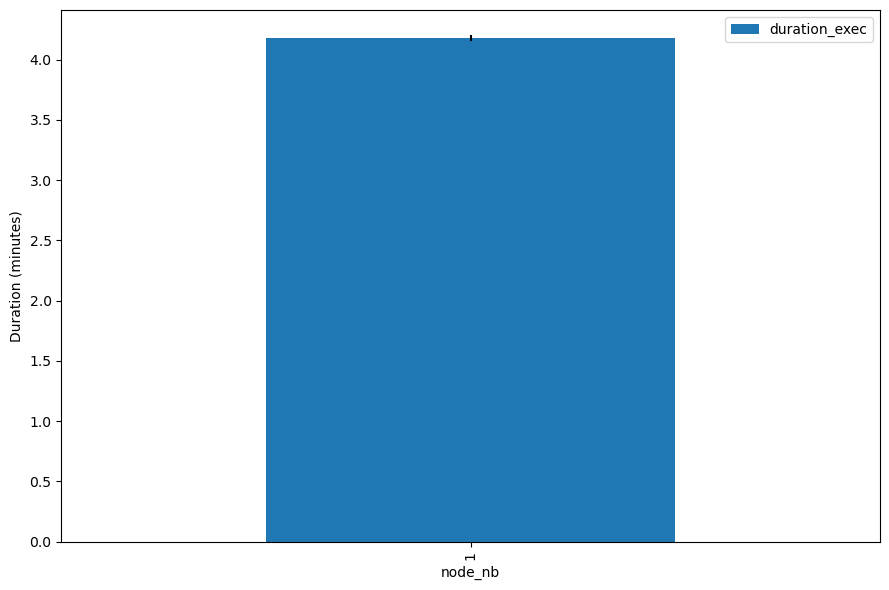

In [40]:
plot_df = jobs
fig, ax = plt.subplots(figsize=(9,6))
les_y = ["duration_exec"]
group = plot_df.groupby("node_nb")[les_y]
group.mean().plot(
    ax=ax,
    # x="node_nb", 
    y=les_y,
    yerr=group.std()[les_y],
    kind="bar"
    )
ax.set_ylabel("Duration (minutes)")
plt.tight_layout()